# 전국 도시 공원 표준 데이터
https://www.data.go.kr/dataset/15012890/standard.do

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
%ls data

상가업소_201709/
상가업소_201709.zip
상권별_업종밀집통계_2016_.csv
서울특별시_자치구별_상권분석_정보_2017_.csv
전국도시공원표준데이터.csv


In [4]:
park = pd.read_csv('data/전국도시공원표준데이터.csv', encoding='euc-kr')
park.shape

(13135, 18)

In [5]:
park.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
3,42800-00004,하리수변공원,수변공원,강원도 양구군 양구읍 하리 643,강원도 양구군 양구읍 하리 643,38.118243,127.981634,18437,NaN,NaN,NaN,NaN,NaN,2010-03-19,강원도 양구군청,033-480-2460,2018-02-28,NaN
4,42800-00005,묘지공원,묘지공원,강원도 양구군 양구읍 죽곡리 산3-1,강원도 양구군 양구읍 죽곡리 산3-1,38.125344,127.999027,178931,NaN,NaN,NaN,NaN,NaN,2010-10-01,강원도 양구군청,033-480-2576,2018-02-28,NaN


In [6]:
from plotnine import *

In [7]:
park['시도'] = park['소재지도로명주소'].str.split(' ', expand=True)[0]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도


In [8]:
park['구군'] = park['소재지도로명주소'].str.split(' ', expand=True)[1]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,시도,구군
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도,양구군


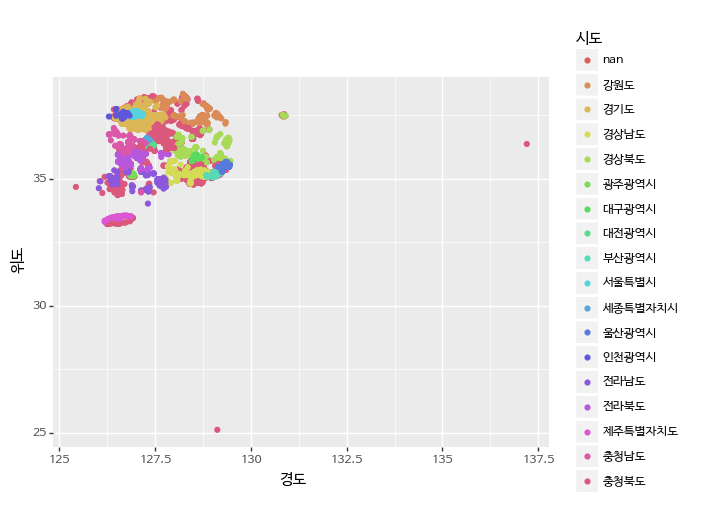

<ggplot: (290572748)>

In [9]:
# 지도를 출력해 보니 특정 지역만 있는거 같다.
# 결측치인 nan 데이터 때문에 다른 데이터가 제대로 보이지 않았다.
# nan 데이터를 제거하고 다시 그려야겠다.
(ggplot(park)
 + aes(x='경도', y='위도', color='시도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [10]:
park_loc_notnull = park.loc[(park['위도'].notnull()) & (park['경도'].notnull()) & park['시도'].notnull()]
park_loc_notnull.shape

(7237, 20)

In [11]:
park_loc_notnull['시도'].value_counts()

경기도        2178
전라북도        779
서울특별시       657
울산광역시       656
경상남도        458
강원도         411
전라남도        381
경상북도        243
대전광역시       231
인천광역시       207
부산광역시       190
제주특별자치도     188
대구광역시       177
광주광역시       164
충청남도        155
충청북도         93
세종특별자치시      69
Name: 시도, dtype: int64

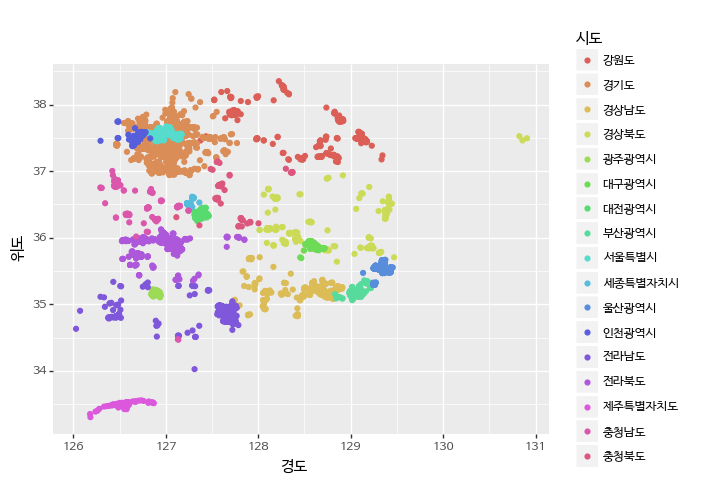

<ggplot: (-9223372036563380066)>

In [12]:
(ggplot(park_loc_notnull)
 + aes(x='경도', y='위도', color='시도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [13]:
# 위에 그린 위도 경도 그래프를 잘못 그린걸까? 경기도 이외의 데이터들이 제대로 그려지지 않은 거 같다.
park_do = park['시도'].value_counts()
park_do = park_do.reset_index()
park_do.columns = ['시도', '합계']
park_do.sort_values(['합계'], ascending=False)

,시도,합계
0,경기도,2178
1,전라북도,779
2,서울특별시,657
3,울산광역시,656
4,경상남도,458
5,강원도,411
6,전라남도,381
7,경상북도,243
8,대전광역시,231
9,인천광역시,207


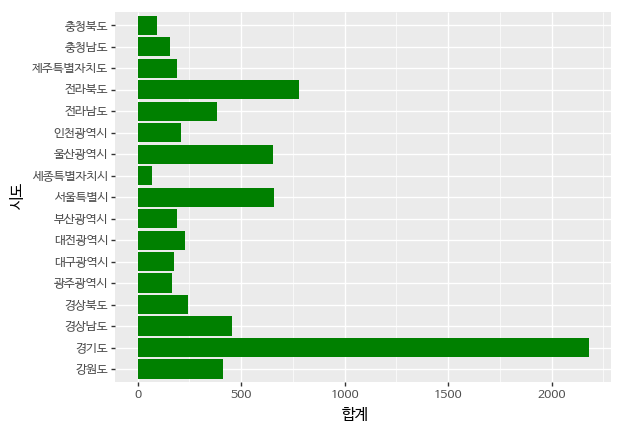

<ggplot: (-9223372036563559771)>

In [14]:
# 경기도가 압도적으로 많다.
(ggplot(park_do)
 + aes(x='시도', y='합계')
 + geom_bar(stat='identity', position='dodge', fill='green')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [15]:
park_type = park['공원구분'].value_counts().reset_index()
park_type.columns = ('공원구분', '합계')
park_type

,공원구분,합계
0,어린이공원,7375
1,근린공원,3148
2,소공원,1723
3,문화공원,205
4,수변공원,199
5,체육공원,162
6,기타,159
7,역사공원,115
8,묘지공원,35
9,도시자연공원,5


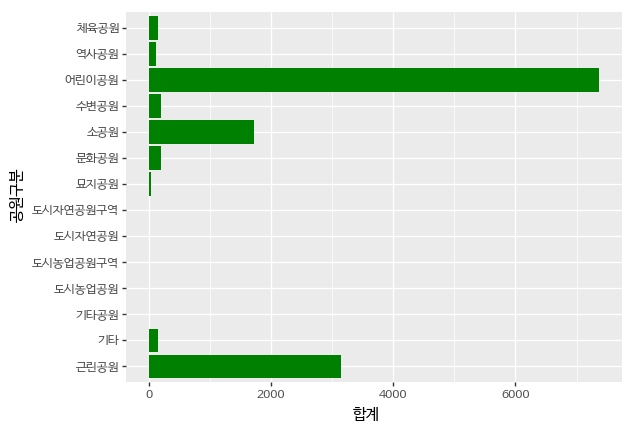

<ggplot: (291240028)>

In [16]:
(ggplot(park_type)
 + aes(x='공원구분', y='합계')
 + geom_bar(stat='identity', position='dodge', fill='green')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

## 경기도
* 경기도에는 가장 많은 공원이 있다. 어떻게 분포되어 있는지 그려보자.

In [17]:
gg = park.loc[park['시도'] == '경기도']
gg.shape

(2178, 20)

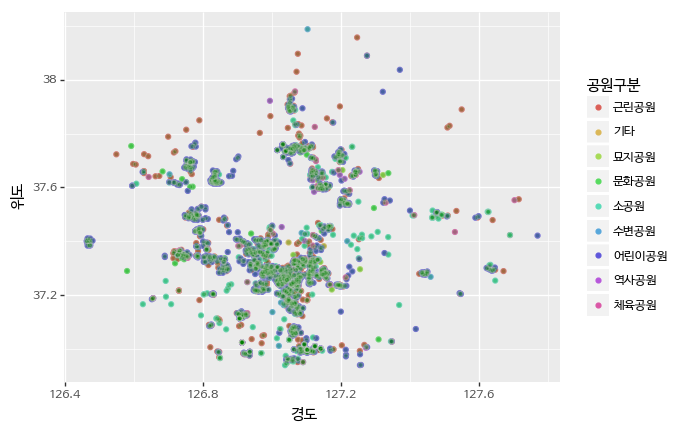

<ggplot: (291424481)>

In [18]:
(ggplot(gg)
 + aes(x='경도', y='위도', color='공원구분') 
 + geom_point()
 + geom_jitter(fill='green', color='lightgray', alpha=0.25)
 + theme(text=element_text(family='NanumBarunGothic'))
)

## 서울특별시

In [19]:
seoul = park.loc[park['시도'] == '서울특별시']
seoul.shape

(657, 20)

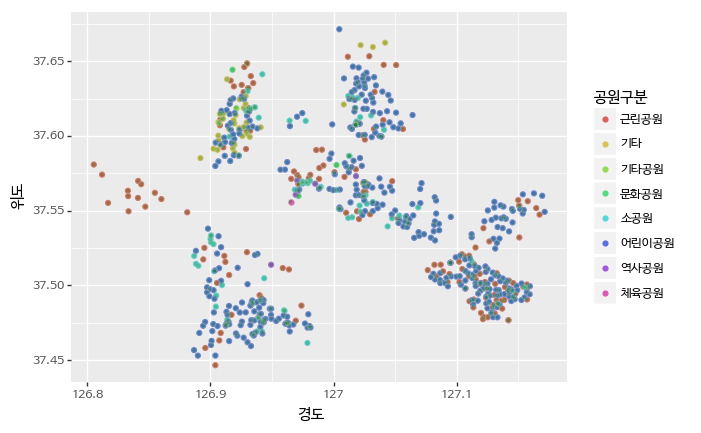

<ggplot: (-9223372036563273293)>

In [20]:
(ggplot(seoul)
 + aes(x='경도', y='위도', color='공원구분') 
 + geom_point()
 + geom_jitter(fill='green', color='lightgray', alpha=0.25)
 + scale_fill_gradient(low = 'green', high = 'brown') 
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [21]:
park['공원구분'].value_counts()

어린이공원       7375
근린공원        3148
소공원         1723
문화공원         205
수변공원         199
체육공원         162
기타           159
역사공원         115
묘지공원          35
도시자연공원         5
도시농업공원         5
도시자연공원구역       2
기타공원           1
도시농업공원구역       1
Name: 공원구분, dtype: int64

In [22]:
seoul_playground = park.loc[(park['공원구분'] == '어린이공원') & (park['시도'] == '서울특별시')]

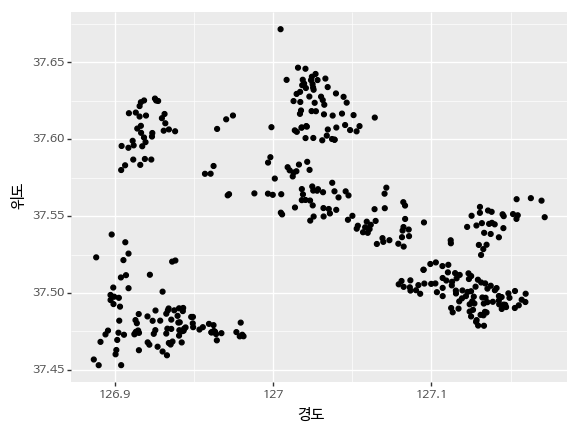

<ggplot: (-9223372036563562236)>

In [23]:
# 특정 지역에는 어린이 공원이 부족해 보인다. 왜 그럴까?
(ggplot(seoul_playground)
 + aes(x='경도', y='위도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [24]:
gu = '강남구 강동구 강북구 강서구 관악구 광진구 구로구 금천구 노원구 도봉구 동대문구 동작구 마포구 서대문구 서초구 성동구 성북구 송파구 양천구 영등포구 용산구 은평구 종로구 중구 중랑구'
gu = gu.split(' ')
print('서울에는 {}개의 구가 있다.'.format(len(gu)))

서울에는 25개의 구가 있다.


In [25]:
# 무악동이 구군 데이터에 잘못 들어와 있다. 전처리 해줄 필요가 있다.
seoul_playground_gu = seoul_playground['구군'].value_counts().reset_index()
seoul_playground_gu_count = seoul_playground_gu.shape[0]
print('아래 데이터를 보니 몇 개 구가 누락된것을 알 수 있다. 전체 {}개 구 중 {}개 구만 있다.'.format(len(gu), seoul_playground_gu_count))
seoul_playground_gu

아래 데이터를 보니 몇 개 구가 누락된것을 알 수 있다. 전체 25개 구 중 14개 구만 있다.


,index,구군
0,송파구,89
1,관악구,64
2,강북구,35
3,은평구,34
4,강동구,28
5,성북구,27
6,성동구,27
7,광진구,23
8,영등포구,18
9,중구,13


* 공공데이터 포털에 확인해 보니 전국도시공원표준데이터.xls 외에 202개의 파일이 더 있는 것이 확인 된다. 
* https://www.data.go.kr/dataset/15012890/standard.do

* 그럼 서울시에 어린이 공원을 포함해 어떤 공원들이 있는지 본다.

In [26]:
# 서울에는 주로 어떤 공원이 있을까?
seoul['공원구분'].value_counts()

어린이공원    384
근린공원     147
소공원       74
기타        41
역사공원       5
문화공원       4
체육공원       1
기타공원       1
Name: 공원구분, dtype: int64

In [27]:
# 경기도는 어떨까?
gg['공원구분'].value_counts()

어린이공원    1243
근린공원      504
소공원       271
체육공원       49
문화공원       48
수변공원       35
역사공원       16
묘지공원        9
기타          3
Name: 공원구분, dtype: int64

In [28]:
park_unique = pd.pivot_table(park, index=['공원구분', '시도'], aggfunc=len)
park_unique.head()

Unnamed: 17     경도  공원면적  공원명  공원보유시설(교양시설)  공원보유시설(기타시설)  \
공원구분 시도                                                                 
근린공원 강원도           78.0   78.0    78   78            78            78   
     경기도          504.0  504.0   504  504           504           504   
     경상남도         100.0  100.0   100  100           100           100   
     경상북도          53.0   53.0    53   53            53            53   
     광주광역시         28.0   28.0    28   28            28            28   

            공원보유시설(운동시설)  공원보유시설(유희시설)  공원보유시설(편익시설)  관리기관명  관리번호   구군  \
공원구분 시도                                                                  
근린공원 강원도              78            78            78     78    78   78   
     경기도             504           504           504    504   504  504   
     경상남도            100           100           100    100   100  100   
     경상북도             53            53            53     53    53   53   
     광주광역시            28            28            28     28    28   28   

            데이터기준일자  소재지도로명주소  소재지지번주소     위도  전화번호  지정고시일  
공원구분 시도                                                     
근린공원 강원도         78        78       78   78.0    78     78  
     경기도        504       504      504  504.0   504    504  
     경상남도       100       100      100  100.0   100    100  
     경상북도        53        53       53   53.0    53     53  
     광주광역시       28        28       28   28.0    28     28

In [29]:
park.columns

Index(['관리번호', '공원명', '공원구분', '소재지도로명주소', '소재지지번주소', '위도', '경도', '공원면적',
       '공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', '전화번호', '데이터기준일자', 'Unnamed: 17',
       '시도', '구군'],
      dtype='object')

In [30]:
park_unique = pd.pivot_table(park, index=['시도', '구군'], columns='공원구분')
park_unique.head()

경도                                                           \
공원구분           근린공원          기타 기타공원 도시농업공원구역 도시자연공원        묘지공원        문화공원   
시도  구군                                                                         
강원도 강릉시  128.877562         NaN  NaN      NaN    NaN         NaN  128.915411   
    고성군         NaN  128.290497  NaN      NaN    NaN         NaN         NaN   
    동해시  129.113660         NaN  NaN      NaN    NaN         NaN         NaN   
    삼척시  129.165181         NaN  NaN      NaN    NaN         NaN         NaN   
    양구군         NaN         NaN  NaN      NaN    NaN  127.999027         NaN   

                                            ...    위도                  \
공원구분            소공원        수변공원       어린이공원 ...  기타공원 도시농업공원구역 도시자연공원   
시도  구군                                      ...                         
강원도 강릉시  128.855840         NaN  128.889063 ...   NaN      NaN    NaN   
    고성군  128.275123         NaN         NaN ...   NaN      NaN    NaN   
    동해시  129.103602  129.123711  129.109900 ...   NaN      NaN    NaN   
    삼척시  129.247329         NaN  129.185845 ...   NaN      NaN    NaN   
    양구군         NaN  127.981634  127.986376 ...   NaN      NaN    NaN   

                                                                          
공원구분          묘지공원       문화공원        소공원       수변공원      어린이공원 역사공원 체육공원  
시도  구군                                                                    
강원도 강릉시        NaN  37.751991  37.810613        NaN  37.775079  NaN  NaN  
    고성군        NaN        NaN  38.244420        NaN        NaN  NaN  NaN  
    동해시        NaN        NaN  37.509552  37.486651  37.507288  NaN  NaN  
    삼척시        NaN        NaN  37.311655        NaN  37.416685  NaN  NaN  
    양구군  38.125344        NaN        NaN  38.118243  38.105019  NaN  NaN  

[5 rows x 24 columns]